# Study of Image classification with modern MLP Mixer model and CKA

**Author:** [Arturo Flores](https://www.linkedin.com/in/afloresalv/)<br>
**Based on (MLP-MIXER):**  https://keras.io/examples/vision/mlp_image_classification/

## Introduction
#####################


This example implements three modern attention-free, multi-layer perceptron (MLP) based models for image
classification, demonstrated on the CIFAR-100 dataset:

1. The [MLP-Mixer](https://arxiv.org/abs/2105.01601) model, by Ilya Tolstikhin et al., based on two types of MLPs.

The purpose of the example is not to compare between these models, as they might perform differently on
different datasets with well-tuned hyperparameters. Rather, it is to show simple implementations of their
main building blocks.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```shell
pip install -U tensorflow-addons
update tensorflow core to 2.7.0
```

# Setup for the MLP-Mixer Architecture

################################################################

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import datetime
import pickle

D:\Program_Files\Anaconda3\envs\AI\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Prepare the data
C1FAR 100 = 100 classes, each 600 images

In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#plt.imshow(x_train[1])

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [3]:
weight_decay = 0.0001
batch_size = 128 # The paper also fine tunes this to 512
num_epochs = 50
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size. Square
patch_size = 8  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of Mixer Layers
num_example = 13

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


## Build a classification model

We implement a method that builds a classifier given the processing blocks. \
Positional Encoding = https://kazemnejad.com/blog/transformer_architecture_positional_encoding/  


In [4]:

def build_classifier(blocks, embedding_dim, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data. 
    augmented = data_augmentation(inputs)
    # Create patches. 
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks. ## (sequential_82)
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor. 
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation) 
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


## Define an experiment

We implement a utility function to compile, train, and evaluate a given model. \
Adam Algorithm with Weight Decay: https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW \
Losses: https://keras.io/api/losses/ \
Reduce learning rate: https://keras.io/api/callbacks/reduce_lr_on_plateau/ \
Logits: https://www.youtube.com/watch?v=icQaFxKa_J0


In [5]:

def run_experiment(model):
    # Create Adam optimizer with weight decay. Regularization that penalizes the increase of weight - with a facto alpha - to correct the overfitting
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        #Negative Log Likelihood = Categorical Cross Entropy
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping regularization callback. 
    # It ends at a point that corresponds to a minimum of the L2-regularized objective
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history, accuracy, top_5_accuracy


## Use data augmentation
Their state is not set during training; it must be set before training, either by initializing them from a precomputed constant, or by "adapting" them on data.

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch extraction as a layer
Atributes and heritage: https://pythones.net/funcion-super-en-python-bien-explicada-ejemplos-oop/ \
Extract Patches: https://www.tensorflow.org/api_docs/python/tf/image/extract_patches \
Reshape: https://www.tensorflow.org/api_docs/python/tf/reshape \
If one component of shape is the special value -1, the size of that dimension is computed so that the total size remains constant. \
Preprocessing data: https://www.tensorflow.org/guide/keras/preprocessing_layers

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        #Extract the shape dimension in the position 0 = columns
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            #Without overlapping, stride horizontally and vertically
            strides=[1, self.patch_size, self.patch_size, 1],
            #Rate: Dilation factor [1 1* 1* 1] controls the spacing between the kernel points.
            rates=[1, 1, 1, 1],
            #Patches contained in the images are considered, no zero padding
            padding="VALID",
        )
        #shape[-1], number of colummns, as well as shape[0]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config().copy()
        config.update ({
            'patch_size' : self.patch_size ,
            'num_patches' : self.num_patches
        })
        return config


## The MLP-Mixer model

The MLP-Mixer is an architecture based exclusively on
multi-layer perceptrons (MLPs), that contains two types of MLP layers:

1. One applied independently to image patches, which mixes the per-location features.
2. The other applied across patches (along channels), which mixes spatial information.

This is similar to a [depthwise separable convolution based model](https://arxiv.org/pdf/1610.02357.pdf)
such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization
instead of batch normalization.

### Implement the MLP-Mixer module

In [8]:

class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

    def get_config(self): 
        config = super(MLPMixerLayer, self).get_config().copy()
        config.update ({
            'num_patches' : num_patches,
            'embedding_dim' : embedding_dim,
            'dropout_rate' : dropout_rate,
        })
        return config

## Build, train, and evaluate the MLP-Mixer model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [9]:
# Report: Learning Curve
def curves(history):
    ymax1 = min(history["loss"])
    xmax1 = history["loss"].index(ymax1)
    ymax2 = min(history["val_loss"])
    xmax2 = history["val_loss"].index(ymax2)
    plt.title("Cross Entropy Loss")
    plt.plot(history["loss"], color = 'blue', label = 'Training')
    plt.plot(history["val_loss"], color = 'orange', label = 'Testing')
    plt.xlabel("Epochs")
    plt.annotate('Max:' + str(round(ymax1,2)) , xy = (xmax1, ymax1), xytext = (xmax1*0.93, 1.07*ymax1), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax2,2)) , xy = (xmax2, ymax2), xytext = (xmax2*0.93, 1.07*ymax2), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlim([0,num_epochs])
    plt.legend()
    plt.show()
    # Graph accuracy
    ymax3 = max(history["acc"])
    xmax3 = history["acc"].index(ymax3)
    ymax4 = max(history["val_acc"])
    xmax4 = history["val_acc"].index(ymax4)
    ymax5 = max(history["top5-acc"])
    xmax5 = history["top5-acc"].index(ymax5)
    ymax6 = max(history["val_top5-acc"])
    xmax6 = history["val_top5-acc"].index(ymax6)
    plt.subplot(2,1,1)
    plt.title('Classification accuracy')
    plt.plot(history['acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax3,2)) , xy = (xmax3, ymax3), xytext = (xmax3*0.93, 1.2*ymax3), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax4,2)) , xy = (xmax4, ymax4), xytext = (xmax4*0.93, 0.7*ymax4), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.subplot(2,1,2)
    plt.title('Classification top5-acc')
    plt.plot(history['top5-acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_top5-acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax5,2)) , xy = (xmax5, ymax5), xytext = (xmax5*0.93, 1.2*ymax5), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax6,2)) , xy = (xmax6, ymax6), xytext = (xmax6*0.87, 1.2*ymax6), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlim([0,num_epochs])
    plt.xlabel("Epochs")
    plt.suptitle("Learning Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Obtain activations + Visualization

In [10]:
# Preprocessing Layers + Patches + One dense layer
def Preprocessing(num_example):
    augmented = data_augmentation(x_train[num_example])
    b = Patches(patch_size, num_patches)(augmented)
    a = layers.Dense(units=embedding_dim)(b)
    inp = tf.reshape(a,[1,embedding_dim,num_patches])
    return inp

In [11]:
# Creates a random vector with indexes of a random batch selection and also regularizes the selected batch
def Batch_Preprocessing(batch_size):
    #Vector with the number of Sample of the Xtrain
    a  = list(range(0,x_train.shape[0]))
    b = random.sample(a,batch_size)
    batch_regularization = list()
    for i in range(0,batch_size):
        inter_result = Preprocessing(b[i])
        batch_regularization.append(inter_result)
    return batch_regularization


In [12]:
def visualize_out(result,layer_number,example):
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.imshow(x_train[example])
    ax1.set_title('Original_Figure, Class: #' + str(y_train[example][0]))
    ax2.imshow(result[layer_number])
    ax2.set_title('Activations of MLP block of the Mixer #: '+ '"' + str(layer_number) + '"')
    return None

In [13]:
def Mixer_Layer_Outputs(model_input, model_output,example):
    #The input is fixed to the beginning of the mlp blocks
    intermediate_model=tf.keras.models.Model(inputs=model_input.input,outputs=model_output.output)
    #This reshape is necessary for the input of the model
    example = tf.reshape(example,[1,num_patches,embedding_dim])
    #Inference
    intermediate_prediction =intermediate_model.predict(example)
    #This reshape is standardize the output
    layactivation = intermediate_prediction.reshape((embedding_dim,num_patches))
    return layactivation

In [14]:
## Computes the outputs of each MLP-mixer Layer
def Mixer_Activations(model, example):
    total_activations = list()
    for i in range(num_blocks):
        model_input = model.layers[4].layers[0]
        model_output = model.layers[4].layers[i]
        int_total_activations = Mixer_Layer_Outputs(model_input, model_output, example)
        total_activations.append(int_total_activations)
    return  total_activations

In [15]:
#Average of layer's activation
def Prom_Mixer_Activations_Blocks(model,batch_regularization):
    sum = list()
    for i in range(0,num_blocks):
        sum_raw = np.zeros((embedding_dim,num_patches))
        sum.append(sum_raw)
    for i in range(0,batch_size):
        mixer_raw = Mixer_Activations(model,batch_regularization[i])
        for i in range(0,num_blocks):
            sum[i] = np.add(mixer_raw[i],sum[i])
    prom_mixer_activations = [ (number / batch_size)  for number in sum]
    return prom_mixer_activations

# CKA

In [16]:
# Files imported from the sleected GitHub https://cka-similarity.github.io/
from CKA_Google import *
import seaborn as sns 
import random
import matplotlib.pyplot as plt 

In [17]:
# Calculates a heatmap according to the selection of a CKA_Kernel (preferred) or CKA_Linear
def Heatmap(result,type,sigma):
    dim = len(result)
    k = (dim - 1)
    heatmap_CKA = np.zeros((dim,dim))
    for i in range(0,dim):
        tr = (dim - 1)
        for j in range(0,dim):
            if type == 'kernel':
                heatmap_CKA[k][tr] = cka(gram_rbf(result[i],sigma),gram_rbf(result[j],sigma))
            elif type == 'linear':
                heatmap_CKA[k][tr] = cka(gram_linear(result[i]),gram_linear(result[j])) 
            else:
                print('There is no such category, try again')
                break

            tr -= 1
        k -= 1
    #print('CKA' + type + 'calculated')
    return heatmap_CKA

In [18]:
#Average of heatmaps (obsolet)
def Prom_Mixer_Heatmaps(batch_result,type):
    mat_heatmaps = list()
    prom_mixer_heatmap_raw = np.zeros((num_blocks,num_blocks))
    for i in range(0,batch_size):
        mixer_activations_raw = Mixer_Activations(batch_result[i])
        heatmap_raw = Heatmap(mixer_activations_raw, type)
        mat_heatmaps.append(heatmap_raw)
        prom_mixer_heatmap_raw = np.add(heatmap_raw,prom_mixer_heatmap_raw)
    prom_mixer_heatmap =  prom_mixer_heatmap_raw/batch_size  
    return prom_mixer_heatmap,mat_heatmaps
        

In [19]:
def visualize_Heatmap(heatmap,type,bl):
    #Number of thats that you want to appear in the plot
    tri = 4
    if type == 'kernel' or type == 'linear':
        dim = len(heatmap)
        axis_labels = list()
        for i in range(0,dim):
            axis_labels_inter = str('%i'%(i+1))
            axis_labels.append(axis_labels_inter)
        _, ax = plt.subplots(figsize=(6,6))
        ax = sns.heatmap(heatmap, xticklabels=axis_labels[::-1], yticklabels=axis_labels[::-1], ax = ax, annot=bl)
        #sns.heatmap(heatmap, xticklabels=2, yticklabels=2, ax = ax, annot=bl, cbar=True)   
        ax.invert_xaxis()
        ax.axhline(y = 0, color='k',linewidth = 4)
        ax.axhline(y = heatmap.shape[1], color = 'k', linewidth = 4)
        ax.axvline(x = 0, color ='k',linewidth = 4)
        ax.axvline(x = heatmap.shape[0], color = 'k', linewidth = 4)

        ax.set_title("CKA-"+ type)   
        ax.set_xlabel("Layer")
        ax.set_ylabel("Layer")
        plt.yticks(rotation=0)
        plt.locator_params(axis='x',nbins=tri)
        plt.locator_params(axis='y',nbins=tri)
        plt.savefig('CKA_'+ type +'.png', dpi=300)
        
    else:
        print('There is no such category, try again')

## Stadistics of the Activations

In [20]:
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter

In [21]:
#Second Argument displays the mean, and the standard deviation 
#Distribution_Act_Layers(bt_result,False)
def Distribution_Act_Layers(result,flag):
    legends = list()
    fig, ax = plt.subplots()
    for i in range(num_blocks):
        x = result[i].flatten(order='C')
        mu, std = norm.fit(x)
        x = np.linspace(x.min(), x.max(), 200)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p*100, linewidth=2)
        if flag:
            legends_i = str('L' + str(i+1) + r'$, \mu=$' + str(round(mu,2)) + r'$, \sigma=$' + str(round(std,2)))
        else:
            legends_i = str('L' + str(i+1))
        legends.append(legends_i)
    ax.set_title('Distribution of Activations for each Layer')
    ax.legend(legends, fontsize ='x-small', fancybox = True)
    ax.set_xlabel('Value')
    ax.set_ylabel('Relative Frequency (%)')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Experiment 1 : Understand Network Architecture

## 1A: Different Depths

### Configure the hyperparameters

In [22]:
weight_decay = 0.0001
batch_size = 128 
num_epochs = 3
dropout_rate = 0.2
learning_rate = 0.005

## Selected Architecture: B/32

image_size = 64  # We'll resize input images to this size. Square
patch_size = 8  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = [256]  # Fixed Embedding Dimension
num_blocks = [4]

#num_blocks = [8,12,24,32]  # Number of Mixer Layers that we want to test

In [23]:
#Create different mlpmixers according to an array of widths or depths
def mlpmixer_iterations(num_patches,experiment,embedding_dim,num_blocks):
    it_blocks = len(num_blocks)
    it_widths = len(embedding_dim)
    for j in range(it_widths):
        for i in range(it_blocks):
            mlpmixer_blocks = keras.Sequential(
            [MLPMixerLayer(num_patches, embedding_dim[j], dropout_rate) for _ in range(num_blocks[i])] # creates the number of block without a 
            )
            mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim[j]) # Returns the model
            history,accuracy, top_5_accuracy = run_experiment(mlpmixer_classifier)
            now = datetime.datetime.now()
            date = now.strftime("%Y-%m-%d_%H-%M")
            #Saving Results
            pwd = 'Results_Article/'+ str(experiment) +'/mlpmixer_'+ str(num_blocks[i]) + 'ly_' + str(embedding_dim[j]) + 'Dc_' + str(date)
            mlpmixer_classifier.save(pwd)
            np.save( pwd + '/history_' + str(date) +'.npy',history.history)
            with open(pwd + '/accuracy.pkl','wb') as file:
                pickle.dump(accuracy,file)
            with open(pwd + '/top5-accuracy.pkl','wb') as file:
                pickle.dump(top_5_accuracy,file)

In [24]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#plt.imshow(x_train[1])

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [25]:
mlpmixer_iterations(num_patches,'1A', embedding_dim,num_blocks)

Epoch 1/3
352/352 [==============================] - 62s 136ms/step - loss: 1.7624 - acc: 0.3677 - top5-acc: 0.8565 - val_loss: 1.4096 - val_acc: 0.4944 - val_top5-acc: 0.9296 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 47s 133ms/step - loss: 1.4456 - acc: 0.4759 - top5-acc: 0.9230 - val_loss: 1.3721 - val_acc: 0.5132 - val_top5-acc: 0.9408 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 10s 33ms/step - loss: 1.2384 - acc: 0.5573 - top5-acc: 0.9512
Test accuracy: 55.73%
Test top 5 accuracy: 95.12%


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_4ly_256Dc_2022-02-21_15-07\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_4ly_256Dc_2022-02-21_15-07\assets


## Verification (optional for 1A and 2A)

### Load the model for the verification
Change paths in this cell

In [27]:
path = 'Results_Article/1A/mlpmixer_4ly_256Dc_2022-02-21_15-07'
#Call the folder
tested_model = tf.keras.models.load_model(path)
#Call the file
tested_history=np.load( path + '/history_2022-02-21_15-07.npy',allow_pickle='TRUE').item()
with open(path + '/accuracy.pkl','rb') as file:
    tested_accuracy = pickle.load(file)

In [ ]:
curves(tested_history)

In [28]:
# Set manually the values of your loaded model
embedding_dim = 256
num_blocks = 4

Random Example

In [29]:
#Run separtely once to avoid randomness
num_example = 39
example_prepro = Preprocessing(num_example)

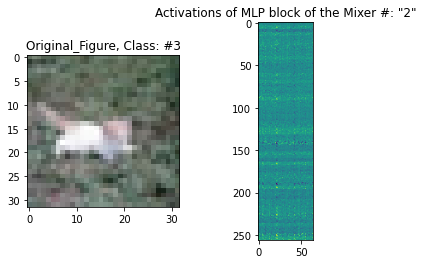

In [30]:
#Select a MixerBlock and visualize the activation
n_MixerLayer = 2

bt_result = Mixer_Activations(tested_model,example_prepro)
visualize_out(bt_result,n_MixerLayer,num_example)

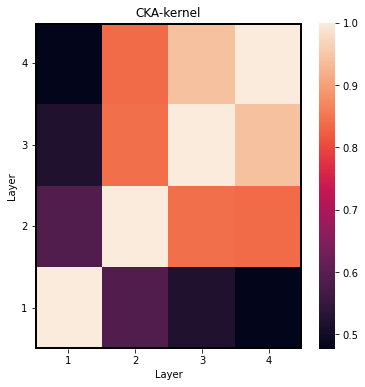

In [31]:
## Heatmap of activations of the random sample
sigma = 1
bt_heatmap_CKA_ran = Heatmap(bt_result,'kernel',sigma)
visualize_Heatmap(bt_heatmap_CKA_ran,'kernel',False)

Batch

In [32]:
#Run separtely once to avoid randomness 
batch_prepro = Batch_Preprocessing(batch_size)

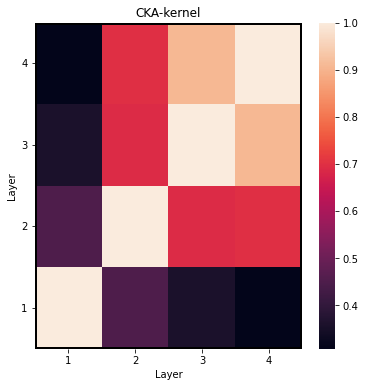

In [34]:
# Heatmap of Average of layer's activation
sigma = 1
A1_ave_mixer_activations = Prom_Mixer_Activations_Blocks(tested_model,batch_prepro)
A1_global_heatmap = Heatmap(A1_ave_mixer_activations,'kernel',sigma)
visualize_Heatmap(A1_global_heatmap,'kernel',False)

# Experiment 2: Different Widths

## 2A

### Configure the hyperparameters

In [35]:
weight_decay = 0.0001
batch_size = 128 
num_epochs = 3
dropout_rate = 0.2
learning_rate = 0.005

## Selected Architecture: B/32

image_size = 64  # We'll resize input images to this size. Square
patch_size = 8  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
num_blocks = [12]  # Fixed Number of Mixer Layers 
embedding_dim = [256] 

#embedding_dim = [256,384,512,640]  # Values that we want to test

In [ ]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
mlpmixer_iterations(num_patches,'2A',embedding_dim,num_blocks)

# Experiment 3: Across Datasets

# 3A

### Configure the hyperparameters

In [36]:
weight_decay = 0.0001
batch_size = 128 
num_epochs = 3
dropout_rate = 0.2
learning_rate = 0.005


## Selected Architecture: B/32

image_size = 64  # We'll resize input images to this size. Square
patch_size = 8  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = 256  # Fixed Embedding Dimension
num_blocks = 4

now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d_%H-%M")

In [37]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

Trained with CIFAR10

In [38]:
for k in range(2):
    mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)] # creates the number of block without a 
    )
    mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim) # Returns the model
    history,accuracy,top_5_accuracy = run_experiment(mlpmixer_classifier)
    #Saving Results
    pwd = 'Results_Article/3A/mlpmixer_' + str(date) + '_CF10_' + str(k+1)
    mlpmixer_classifier.save(pwd)
    np.save( pwd + '/history_' + str(date) +'.npy',history.history)
    with open(pwd + '/accuracy.pkl','wb') as file:
        pickle.dump(accuracy,file)
    with open(pwd + '/top5-accuracy.pkl','wb') as file:
        pickle.dump(top_5_accuracy,file)

Epoch 1/3
352/352 [==============================] - 52s 135ms/step - loss: 1.7368 - acc: 0.3734 - top5-acc: 0.8583 - val_loss: 1.4954 - val_acc: 0.4650 - val_top5-acc: 0.9086 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 47s 133ms/step - loss: 1.4424 - acc: 0.4782 - top5-acc: 0.9221 - val_loss: 1.3464 - val_acc: 0.5194 - val_top5-acc: 0.9420 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 10s 32ms/step - loss: 1.3548 - acc: 0.5198 - top5-acc: 0.9355
Test accuracy: 51.98%
Test top 5 accuracy: 93.55%


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_CF10_1\assets


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_CF10_1\assets


Epoch 1/3
352/352 [==============================] - 53s 138ms/step - loss: 1.7377 - acc: 0.3711 - top5-acc: 0.8592 - val_loss: 1.3939 - val_acc: 0.4962 - val_top5-acc: 0.9290 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 46s 130ms/step - loss: 1.4367 - acc: 0.4810 - top5-acc: 0.9235 - val_loss: 1.2866 - val_acc: 0.5390 - val_top5-acc: 0.9454 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 9s 29ms/step - loss: 1.2785 - acc: 0.5481 - top5-acc: 0.9398
Test accuracy: 54.81%
Test top 5 accuracy: 93.98%


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_CF10_2\assets


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_CF10_2\assets


In [39]:
#Dataset for training 
num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

Trained with CIFAR 100

In [40]:
for k in range(2):
    mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)] # creates the number of block without a 
    )
    mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim) # Returns the model
    history,accuracy,top_5_accuracy = run_experiment(mlpmixer_classifier)
    #Saving Results
    pwd = 'Results_Article/3A/mlpmixer_' + str(date) + '_CF100_' + str(k+1)
    mlpmixer_classifier.save(pwd)
    np.save( pwd + '/history_' + str(date) +'.npy',history.history)
    with open(pwd + '/accuracy.pkl','wb') as file:
        pickle.dump(accuracy,file)
    with open(pwd + '/top5-accuracy.pkl','wb') as file:
        pickle.dump(top_5_accuracy,file)

Epoch 1/3
352/352 [==============================] - 52s 137ms/step - loss: 3.8623 - acc: 0.1139 - top5-acc: 0.3199 - val_loss: 3.4493 - val_acc: 0.1860 - val_top5-acc: 0.4540 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 47s 135ms/step - loss: 3.3910 - acc: 0.1861 - top5-acc: 0.4565 - val_loss: 3.2546 - val_acc: 0.2214 - val_top5-acc: 0.4982 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 9s 28ms/step - loss: 3.0050 - acc: 0.2701 - top5-acc: 0.5613
Test accuracy: 27.01%
Test top 5 accuracy: 56.13%


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_CF100_1\assets


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_CF100_1\assets


Epoch 1/3
352/352 [==============================] - 48s 122ms/step - loss: 3.8370 - acc: 0.1159 - top5-acc: 0.3259 - val_loss: 3.4368 - val_acc: 0.1882 - val_top5-acc: 0.4496 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 44s 125ms/step - loss: 3.3591 - acc: 0.1960 - top5-acc: 0.4681 - val_loss: 3.2051 - val_acc: 0.2258 - val_top5-acc: 0.5118 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 9s 30ms/step - loss: 3.0013 - acc: 0.2660 - top5-acc: 0.5617
Test accuracy: 26.6%
Test top 5 accuracy: 56.17%


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_CF100_2\assets


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_CF100_2\assets


Untrained

In [41]:
mlpmixer_blocks = keras.Sequential(
[MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)] # creates the number of block without a 
)
mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim) # Returns the model
pwd = 'Results_Article/3A/mlpmixer_' + str(date) + '_Untrained'
mlpmixer_classifier.save(pwd)
#np.save( pwd + '/history_' + str(date) +'.npy',history.history)
#with open(pwd + '/accuracy.pkl','wb') as file:
#    pickle.dump(accuracy,file)
#with open(pwd + '/top5-accuracy.pkl','wb') as file:
#    pickle.dump(top_5_accuracy,file)

INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_Untrained\assets


INFO:tensorflow:Assets written to: Results_Article/3A/mlpmixer_2022-02-21_15-20_Untrained\assets


### Load the models

Change the path below

In [42]:
path = 'Results_Article/3A/mlpmixer_2022-02-21_15-20_'
global_models = list()
#Call the folder
C10_mlpmixer_1 = tf.keras.models.load_model(path + 'CF10_1')
global_models.append(C10_mlpmixer_1)
C10_mlpmixer_2 = tf.keras.models.load_model(path + 'CF10_2')
global_models.append(C10_mlpmixer_2)
C100_mlpmixer_1 = tf.keras.models.load_model(path + 'CF100_1')
global_models.append(C100_mlpmixer_1)
C100_mlpmixer_2 = tf.keras.models.load_model(path + 'CF100_2')
global_models.append(C100_mlpmixer_2)
Unt_mlpmixer = tf.keras.models.load_model(path + 'Untrained')
global_models.append(Unt_mlpmixer)

In [43]:
#Run Once to Avoid Randomness
batch_prepro = Batch_Preprocessing(batch_size)

## Intialization before testing

In [44]:
def across_datasets(global_models,batch_prepro,type,sigma):
    total_activations = list()
    plot_raw = list()
    plot_total = list()
    for k in range(len(global_models)):
        tested_model = global_models[k] 
        ave_mixer_activations = Prom_Mixer_Activations_Blocks(tested_model,batch_prepro)
        total_activations.append(ave_mixer_activations)
        
    for pairs in set:
        comp_1 = total_activations[pairs[0]]
        comp_2 = total_activations[pairs[1]]
        plot_raw = list()
        for i in range(num_blocks):
            if type == 'rbf':
                inter_row = cka(gram_rbf(comp_1[i],sigma),gram_rbf(comp_2[i],sigma))
            elif type == 'linear':
                inter_row = cka(gram_linear(comp_1[i]),gram_linear(comp_2[i]))
            plot_raw.append(inter_row)
        plot_total.append(plot_raw)
    return plot_total

In [45]:
sigma = 1
type = 'linear'

#Pairs of models that are going to be compared according to the order in the matriz
set = [[0,1],[2,3],[0,2],[0,4],[2,4]]
label_set = ['CIFAR-10 Net vs. CIFAR-10 Net',
            'CIFAR-100 Net vs. CIFAR-100 Net',
            'CIFAR-10 Net vs. CIFAR-100 Net ',
            'CIFAR-10 Net vs. Untrained',
            'CIFAR-100 Net vs. Untrained']
num_models_set = len(set)



### Tested on CIFAR 10

In [46]:
# Dataset for testing

num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), _ = keras.datasets.cifar10.load_data()

In [47]:
# The experiment on the paper is with the linear type
plot_total_1 = across_datasets(global_models,batch_prepro,type,sigma=None)
with open('Results_Article/3A/plot_total_C10.pkl','wb') as file:
    pickle.dump(plot_total_1,file)

### Tested on CIFAR 100

In [ ]:
# Dataset for testing

num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), _ = keras.datasets.cifar100.load_data()

In [ ]:
# The experiment on the paper is with the linear type
plot_total_2 = across_datasets(global_models,batch_prepro,type,sigma=None)
with open('Results_Article/3A/plot_total_C100.pkl','wb') as file:
    pickle.dump(plot_total_2,file)


### Tested on MNIST: (Appendix 6A)


In [ ]:
# Dataset for testing

num_classes = 10
input_shape = (28, 28)
(x_train, y_train), _ = keras.datasets.mnist.load_data()

In [ ]:
plot_total_3 = across_datasets(global_models,batch_prepro,type,sigma=None)
with open('Results_Article/6A/plot_total_MNIST.pkl','wb') as file:
    pickle.dump(plot_total_3,file)

### Verification (Optional for 3A)

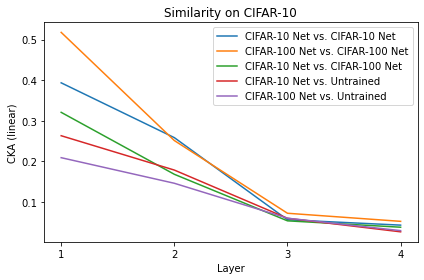

In [48]:
tested_plot = plot_total_1
name = '_tested_C10'
######################################################
x = list(range(1,num_blocks+1))
for j in range(num_models_set):
    plt.plot(x,tested_plot[j], label = label_set[j])
plt.xlabel('Layer')
plt.ylabel('CKA ('+ type +')')
plt.locator_params(axis='x', nbins=num_blocks)
plt.title('Similarity on CIFAR-10')
plt.tight_layout()
plt.legend()
plt.savefig('Results_Article/3A/Similarity_'+ type + name +'.png') 
plt.show()

# Experiment 4: Sanity Check

# 4A

In [49]:
def mlpmixer_generator(num_models):
    now = datetime.datetime.now()
    date = now.strftime("%Y-%m-%d_%H-%M")
    for i in range(num_models):
        mlpmixer_blocks = keras.Sequential(
        [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)] # creates the number of block without a 
        )
        mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim) # Returns the model
        history,accuracy, top_5_accuracy = run_experiment(mlpmixer_classifier)
        #Saving Results
        pwd = 'Results_Article/4A_SC/mlpmixer_B-32_'  + str(date) + '_' + str(i+1)
        mlpmixer_classifier.save(pwd)
        np.save( pwd + '/history_' + str(date) +'.npy',history.history)
        with open(pwd + '/accuracy.pkl','wb') as file:
            pickle.dump(accuracy,file)
        with open(pwd + '/top5-accuracy.pkl','wb') as file:
            pickle.dump(top_5_accuracy,file)

In [50]:
#Available types = 'rbf' or 'linear'
def sanity_check(total_activations,num_models,num_blocks,type,sigma):
    row = []
    total_events = 0
    positive_events = 0
    for i in range(num_models-1):
        comp_1 = total_activations[i]
        for j in range(i+1,num_models):
            comp_2 = total_activations[j]
            for m in range(num_blocks):
                for n in range(num_blocks):
                    if type == 'rbf':
                        inter_row = cka(gram_rbf(comp_1[m],sigma),gram_rbf(comp_2[n],sigma))
                    elif type == 'linear':
                        inter_row = cka(gram_linear(comp_1[m]),gram_linear(comp_2[n]))
                    row.append(inter_row)
                b = [i for i, x in enumerate(row) if x == max(row)]
                if len(b) == 1:
                    if b[0] == m:
                        #print(row)
                        #print('Hello, Layer %i'%(m))
                        positive_events += 1
                    else:
                        pass
                else:
                    pass
                total_events +=1
                row=[]
    return positive_events, total_events

### Configure the hyperparameters

In [54]:
weight_decay = 0.0001
batch_size = 128 
num_epochs = 3
dropout_rate = 0.2
learning_rate = 0.005

## Selected Architecture: B/32

image_size = 64  # We'll resize input images to this size. Square
patch_size = 8  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = 256  # Fixed Embedding Dimension
num_blocks = 4


num_models = 4
#num_models = 10 selected
rbf_index = [0.2,0.4,0.8]

In [55]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), _ = keras.datasets.cifar10.load_data()

In [56]:
mlpmixer_generator(num_models)

Epoch 1/3
352/352 [==============================] - 52s 137ms/step - loss: 1.7151 - acc: 0.3791 - top5-acc: 0.8660 - val_loss: 1.4318 - val_acc: 0.4850 - val_top5-acc: 0.9284 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 47s 134ms/step - loss: 1.4493 - acc: 0.4753 - top5-acc: 0.9217 - val_loss: 1.2852 - val_acc: 0.5370 - val_top5-acc: 0.9504 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 11s 33ms/step - loss: nan - acc: 0.0113 - top5-acc: 0.0548
Test accuracy: 1.13%
Test top 5 accuracy: 5.48%


INFO:tensorflow:Assets written to: Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_1\assets


INFO:tensorflow:Assets written to: Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_1\assets


Epoch 1/3
352/352 [==============================] - 54s 139ms/step - loss: 1.7306 - acc: 0.3799 - top5-acc: 0.8641 - val_loss: 1.4480 - val_acc: 0.4710 - val_top5-acc: 0.9252 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 48s 136ms/step - loss: 1.4440 - acc: 0.4798 - top5-acc: 0.9222 - val_loss: 1.3293 - val_acc: 0.5224 - val_top5-acc: 0.9394 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 11s 33ms/step - loss: nan - acc: 0.0114 - top5-acc: 0.0575
Test accuracy: 1.14%
Test top 5 accuracy: 5.75%


INFO:tensorflow:Assets written to: Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_2\assets


INFO:tensorflow:Assets written to: Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_2\assets


Epoch 1/3
352/352 [==============================] - 53s 138ms/step - loss: 1.7463 - acc: 0.3771 - top5-acc: 0.8584 - val_loss: 1.4348 - val_acc: 0.4810 - val_top5-acc: 0.9276 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 48s 136ms/step - loss: 1.4404 - acc: 0.4810 - top5-acc: 0.9231 - val_loss: 1.3334 - val_acc: 0.5054 - val_top5-acc: 0.9440 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 11s 34ms/step - loss: nan - acc: 0.0107 - top5-acc: 0.0582
Test accuracy: 1.07%
Test top 5 accuracy: 5.82%


INFO:tensorflow:Assets written to: Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_3\assets


INFO:tensorflow:Assets written to: Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_3\assets


Epoch 1/3
352/352 [==============================] - 53s 138ms/step - loss: 1.7319 - acc: 0.3779 - top5-acc: 0.8625 - val_loss: 1.4350 - val_acc: 0.4878 - val_top5-acc: 0.9240 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 48s 137ms/step - loss: 1.4564 - acc: 0.4741 - top5-acc: 0.9214 - val_loss: 1.3057 - val_acc: 0.5276 - val_top5-acc: 0.9442 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 11s 33ms/step - loss: nan - acc: 0.0121 - top5-acc: 0.0529
Test accuracy: 1.21%
Test top 5 accuracy: 5.29%


INFO:tensorflow:Assets written to: Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_4\assets


INFO:tensorflow:Assets written to: Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_4\assets


### Load the models

Change the path below

In [57]:
path = 'Results_Article/4A_SC/mlpmixer_B-32_2022-02-21_15-47_'
total_models = list()
for k in range(num_models):  
    current_model = tf.keras.models.load_model(path + str(k+1))
    total_models.append(current_model)

In [58]:
#Run this cell once to avoid randomness
batch_prepro = Batch_Preprocessing(batch_size)

In [59]:
total_activations = list()
for k in range(num_models):
    tested_model = total_models[k] 
    ave_mixer_activations = Prom_Mixer_Activations_Blocks(tested_model,batch_prepro)
    total_activations.append(ave_mixer_activations)

In [60]:
pwd='Results_Article/4A_SC'
for sigma in rbf_index:
    positive_events, total_events = sanity_check(total_activations, num_models, num_blocks,'rbf',sigma)
    SC_accuracy = (positive_events/total_events) 
    print(f"The Sanity check with a CKA RFF: {sigma} has an accuracy of {round(SC_accuracy * 100, 2)}%")
    #Multiplying by 100 to ensure proper saving of the file
    with open(pwd + '/SCaccuracy_RBF'+ str(round(sigma*100))  +'.pkl','wb') as file:
        pickle.dump(SC_accuracy,file)

The Sanity check with a CKA RFF: 0.2 has an accuracy of 25.0%
The Sanity check with a CKA RFF: 0.4 has an accuracy of 54.17%
The Sanity check with a CKA RFF: 0.8 has an accuracy of 29.17%


In [61]:
positive_events, total_events = sanity_check(total_activations, num_models, num_blocks,'linear',sigma=None)
SC_accuracy = (positive_events/total_events) 
print(f"The Sanity check with a CKA linear has an accuracy of {round(SC_accuracy * 100, 2)}%")
with open(pwd + '/SCaccuracy_linear.pkl','wb') as file:
        pickle.dump(SC_accuracy,file)

The Sanity check with a CKA linear has an accuracy of 33.33%


# Appendix

## 5: Internal Behavior

In [62]:
weight_decay = 0.0001
batch_size = 128 
num_epochs = 3
dropout_rate = 0.2
learning_rate = 0.005

## Selected Architecture: B/32

image_size = 64  # We'll resize input images to this size. Square
patch_size = 8  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = 256  # Fixed Embedding Dimension
num_blocks = 4

sigma = 1
type = 'kernel' # 'kernel' or 'linear'

now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d_%H-%M")
path = 'Results_Article/5Appendix/mlpmixer_' + str(date) + '_independent'

In [63]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), _ = keras.datasets.cifar10.load_data()

In [64]:
def Mixer_Layer_Outputs2(model,example,shape):
    intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=model.output)
    #This reshape is necessary for the input of the model
    example = tf.reshape(example,[1,shape[0],shape[1]])
    #Inference
    intermediate_prediction =intermediate_model.predict(example)
    #This reshape is standardize the output
    layactivation = intermediate_prediction.reshape((embedding_dim,num_patches))
    return layactivation

In [65]:
## Computes the outputs of each MLP-mixer Layer
def Mixer_Activations_2(model,example):
    total_activations = list()
    for i in range(num_blocks):
        #Shape of the input for the mlp1
        shape=(embedding_dim,num_patches)
        modelf = model.layers[4].layers[i].mlp1
        int_total_activations = Mixer_Layer_Outputs2(modelf,example,shape)
        #Shape of the input for the mlp2
        total_activations.append(int_total_activations)
        shape=(num_patches,embedding_dim)
        modelf = model.layers[4].layers[i].mlp2
        int_total_activations = Mixer_Layer_Outputs2(modelf,example,shape)
        total_activations.append(int_total_activations)
    return total_activations

In [66]:
def Prom_Mixer_Activations_Blocks_2(model,batch_regularization):
    sum = list()
    for i in range(0,2*num_blocks):
        sum_raw = np.zeros((embedding_dim,num_patches))
        sum.append(sum_raw)
    for i in range(0,batch_size):
        mixer_raw = Mixer_Activations_2(model,batch_regularization[i])
        for i in range(0,2*num_blocks):
            sum[i] = np.add(mixer_raw[i],sum[i])
    prom_mixer_activations = [ (number / batch_size)  for number in sum]
    return prom_mixer_activations

In [67]:
mlpmixer_blocks = keras.Sequential(
[MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)] # creates the number of block without a 
)
mlpmixer_independent= build_classifier(mlpmixer_blocks,embedding_dim) # Returns the model

In [68]:
#Run once to avoid randomness
batch_prepro = Batch_Preprocessing(batch_size)

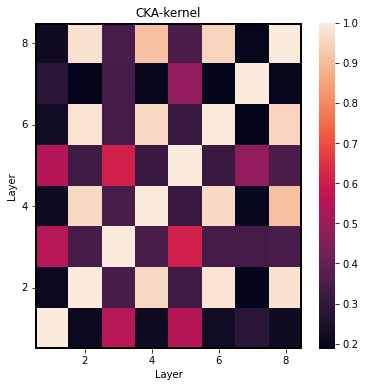

In [74]:
#After training, this cell is going to be same as the after training heatmap
A5_bt_ave_mixer_activations = Prom_Mixer_Activations_Blocks_2(mlpmixer_independent,batch_prepro)
A5_bt_global_heatmap = Heatmap(A5_bt_ave_mixer_activations,type,sigma)
visualize_Heatmap(A5_bt_global_heatmap,type,False)

In [70]:
history = run_experiment(mlpmixer_independent)
mlpmixer_independent.save(path)

Epoch 1/3
352/352 [==============================] - 55s 139ms/step - loss: 1.7307 - acc: 0.3802 - top5-acc: 0.8621 - val_loss: 1.4363 - val_acc: 0.4822 - val_top5-acc: 0.9278 - lr: 0.0050
Epoch 2/3
352/352 [==============================] - 48s 138ms/step - loss: 1.4415 - acc: 0.4806 - top5-acc: 0.9219 - val_loss: 1.3803 - val_acc: 0.5074 - val_top5-acc: 0.9334 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 11s 34ms/step - loss: nan - acc: 0.0129 - top5-acc: 0.0528
Test accuracy: 1.29%
Test top 5 accuracy: 5.28%


INFO:tensorflow:Assets written to: Results_Article/5Appendix/mlpmixer_2022-02-21_16-10_independent\assets


INFO:tensorflow:Assets written to: Results_Article/5Appendix/mlpmixer_2022-02-21_16-10_independent\assets


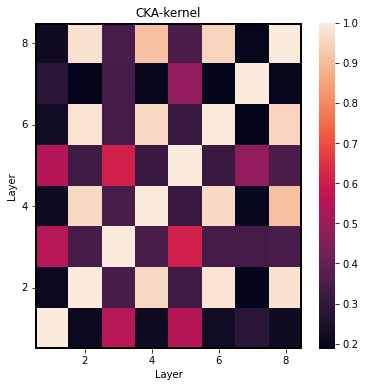

In [71]:
A5_at_ave_mixer_activations = Prom_Mixer_Activations_Blocks_2(mlpmixer_independent,batch_prepro)
A5_at_global_heatmap = Heatmap(A5_at_ave_mixer_activations,type,sigma)
visualize_Heatmap(A5_at_global_heatmap,type,False)


In [75]:
with open(path + '/heatmap_bt.pkl','wb') as file:
    pickle.dump(A5_bt_global_heatmap,file)

In [73]:
with open(path + '/heatmap_at.pkl','wb') as file:
    pickle.dump(A5_at_global_heatmap,file)

In [ ]:
with open(path + '/heatmap_at.pkl','rb') as file:
    tested_heatmap = pickle.load(file)